In [106]:
###############################################
# Week 10 Challenge Part 1 API SQLite Connection & Landing Page

#Imprt dependencies
%matplotlib inline
from matplotlib import style
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates


In [107]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [108]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [109]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
# Create the inspector and connect it to the engine
inspector = inspect(engine)
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [110]:
# Using the inspector to print the column names within the 'measurement' table and its types
# The purpose is to identify the data types by table/class

print("----------measurement--------")
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])


print("----------station--------")
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

----------measurement--------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
----------station--------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [111]:
# reflect an existing database into a new model using automap
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [112]:
# Save references to each table
Measurement  = Base.classes.measurement
Station      = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [113]:
# Find the most recent date in the data set & label as latest_date 
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#'2017-08-23'

('2017-08-23',)

Latest Date:  ('2017-08-23',)
Query Date:  2016-08-23


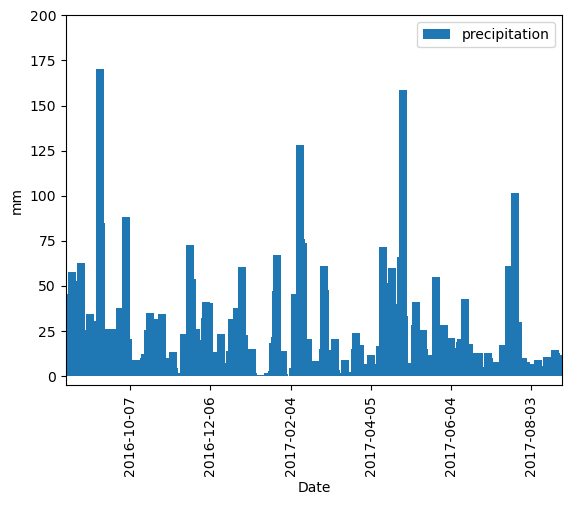

In [114]:

# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print("Latest Date: ",latest_date)

# Calculate the date one year from the last date in data set.
#using value latest_date '2017-08-23' create query_date from 12 months ago.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

# Perform a query to retrieve the data and precipitation scores
results_12m = session.query(Measurement.prcp , Measurement.date).\
                        filter(Measurement.date>=query_date).all()

prcp_rows = [{"Date": result[1], "precipitation": result[0]} for result in results_12m]
prcp_rows
# Save the query results as a Pandas DataFrame. Explicitly set the column names

prcp_12m_df =pd.DataFrame(prcp_rows, columns= ["Date","precipitation"])
prcp_12m_df.set_index("Date",inplace=True)

# # Sort the dataframe by date
#Clean by dropping NAvalues
cleanprcp_12m_df = prcp_12m_df.sort_values(by=["Date"], ascending=True)
cleanprcp_12m_df = cleanprcp_12m_df.dropna()
cleanprcp_12m_df.head()

#group by date and select maxto plot
cleanprcp_group_df = cleanprcp_12m_df.groupby('Date')
cleanprcp_group_max = cleanprcp_group_df.max()
cleanprcp_group_max

# # Use Pandas Plotting with Matplotlib to plot the data
cleanprcp_group_max.plot.bar(width=6)
plt.xlabel("Date")
plt.ylabel("mm")
plt.ylim(-5,200)
#plt.xticks(np.arange(2), ['2016-08-23', '2017-07-10'])  # Set text labels.
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60)) 
#plt.xticks([]) 
plt.show()


In [115]:
# Use Pandas to calculate the summary statistics for the precipitation data
cleanprcp_12m_df.describe()



,precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [116]:
# Design a query to calculate the total number of stations in the dataset
cnt_station = session.query(Measurement).group_by(Measurement.station).count()
print(cnt_station)

#is the same if use Station class.

9


In [117]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_stations = engine.execute(f"Select station, count(station) from Measurement where 'pcrp' is not NULL group by station order by count(station) desc;")
most_stations.fetchmany(10)

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [118]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# "tobs"
#the below is of ALL 
sel = [Measurement.station,
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs) ]

most_active = session.query(*sel).\
    filter(Measurement.station =="USC00519281").\
    group_by(Measurement.station)

most_active.first()


('USC00519281', 12.2, 29.4, 22.03582251082252)

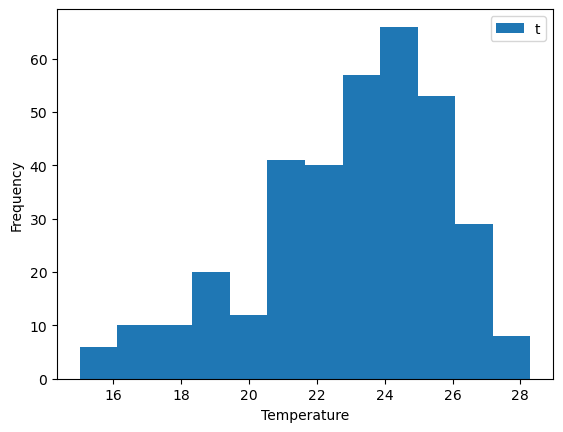

In [119]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# most_active_data = engine.execute(f"Select pcrp from Measurement where station = 'USC00519281' and pcrp is NOT NULL ;")
# 12 Bins


# Perform a query to retrieve the data and precipitation scores
results__temp_12m = session.query(Measurement.tobs , Measurement.date, Measurement.station).\
                        filter(Measurement.date>=query_date).all()


prcp_temp_rows = [{"Date": result[1], "tobs": result[0], "station": result[2]} for result in results__temp_12m]
prcp_temp_rows
# Save the query results as a Pandas DataFrame. Explicitly set the column names

results__temp_12m_df =pd.DataFrame(prcp_temp_rows, columns= ["Date","tobs","station"])
results__temp_12m_df.set_index("Date",inplace=True)
results__temp_12m_df

#get temp for top station only
most_active = "USC00519281"
most_act_temp_df = results__temp_12m_df.loc[results__temp_12m_df["station"]==most_active]
most_temp_df = most_act_temp_df.drop(columns="station")
#most_temp_df

# # # # Sort the dataframe by date
group_most_temp = most_temp_df.groupby('Date')
clean_most_temp = group_most_temp.max()
clean_most_temp

plt.hist(clean_most_temp['tobs'], bins =12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend("tobs")


# Close Session

In [120]:
# Close Session
session.close()